In [5]:
import CONSTANTS
from functions import *
import warnings
import torch
import torch.nn as nn
import math
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from transformer_classes import *
from tqdm import tqdm
from sklearn.metrics import *

warnings.filterwarnings('ignore')

# Transformer

Objective: predict change in BTC price given features

## Prepare data
Create tupled dataset


In [9]:
data = pd.read_csv(f'../{fullDataPath('BTC')}')
data

,time,low,high,open,close,volume,change,pct_change,timestamp,value,...,position,title,source,link,thumbnail,thumbnail_small,date,text,score,sentiment
0,2025-06-21,102217.08,104013.64,103317.79,102272.72,1656.078825,-1045.07,-1.011510,1970-01-01,48.0,...,5.0,Bitcoin Knots gain ground: Will a chain split ...,"{'name': 'Cointelegraph', 'icon': 'https://enc...",https://cointelegraph.com/news/bitcoin-knots-c...,https://images.cointelegraph.com/cdn-cgi/image...,https://news.google.com/api/attachments/CC8iK0...,2025-06-21,Bitcoin Knots gain ground: Will a chain split ...,-57.644907,negative
1,2025-06-21,102217.08,104013.64,103317.79,102272.72,1656.078825,-1045.07,-1.011510,1970-01-01,48.0,...,12.0,Bitcoin Suddenly Braced For $37 Trillion Fed P...,"{'name': 'Forbes', 'icon': 'https://encrypted-...",https://www.forbes.com/sites/digital-assets/20...,https://imageio.forbes.com/specials-images/ima...,https://news.google.com/api/attachments/CC8iK0...,2025-06-21,"ByBilly Bambrough\n\nByBilly Bambrough,\n Seni...",0.062427,neutral
2,2025-06-21,102217.08,104013.64,103317.79,102272.72,1656.078825,-1045.07,-1.011510,1970-01-01,48.0,...,13.0,"Bitcoin Price Breakdown Spurs Sell-Offs, Analy...","{'name': 'TradingView', 'icon': 'https://encry...",https://www.tradingview.com/news/newsbtc:765f7...,https://s.tradingview.com/static/images/illust...,https://news.google.com/api/attachments/CC8iK0...,2025-06-21,The Bitcoin price crashed from as high as $106...,0.031643,neutral
3,2025-06-21,102217.08,104013.64,103317.79,102272.72,1656.078825,-1045.07,-1.011510,1970-01-01,48.0,...,14.0,Bitcoin (BTC) Price Prediction for June 21,"{'name': 'U.Today', 'icon': 'https://encrypted...",https://u.today/bitcoin-btc-price-prediction-f...,https://u.today/sites/default/files/styles/160...,https://news.google.com/api/attachments/CC8iK0...,2025-06-21,Disclaimer: The opinions expressed by our writ...,-0.004051,neutral
4,2025-06-21,102217.08,104013.64,103317.79,102272.72,1656.078825,-1045.07,-1.011510,1970-01-01,48.0,...,15.0,Bitcoin Price Watch: Downtrend Persists Amid M...,"{'name': 'Bitcoin.com News', 'icon': 'https://...",https://news.bitcoin.com/bitcoin-price-watch-d...,https://static.news.bitcoin.com/wp-content/upl...,https://news.google.com/api/attachments/CC8iI0...,2025-06-21,Bitcoin Price Watch: Downtrend Persists Amid M...,-0.000759,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,2024-06-26,60656.80,62470.00,61794.47,60816.68,11392.798350,-977.79,-1.582326,2024-06-26,46.0,...,0.0,-,-,-,-,-,NaN,-,0.000000,-
651,2024-06-25,60217.36,62400.00,60262.16,61789.71,15201.582477,1527.55,2.534841,2024-06-25,44.0,...,0.0,-,-,-,-,-,NaN,-,0.000000,-
652,2024-06-24,58414.28,63343.91,63169.36,60263.00,21418.045946,-2906.36,-4.600901,2024-06-24,49.0,...,0.0,-,-,-,-,-,NaN,-,0.000000,-
653,2024-06-23,63125.75,64499.95,64235.00,63171.43,2054.790924,-1063.57,-1.655748,2024-06-23,51.0,...,0.0,-,-,-,-,-,NaN,-,0.000000,-


In [10]:
# Convert time to datetime if it's not already
data['time'] = pd.to_datetime(data['time'], errors='coerce')
data = data.dropna(subset=['time'])

# Extract date component
data['date'] = data['time'].dt.date

# Group by date and aggregate values (one row per day)
# Hard coded change later
daily_data = (
    data
    .groupby('date')
    .agg(
        close=('close', 'last'),  # Take the last close price of the day
        avg_sentiment=('score', 'mean'),  # Average sentiment for the day
        tweet_count=('score', 'count'),   # Number of observations per day
        volume=('volume', 'last'),          # Total volume for the day
        BB_Lower=('BB_Lower', 'last'),  # Last value of BB lower band
        BB_Middle=('BB_Middle', 'last'),  # Last value of BB middle band
        BB_Upper=('BB_Upper', 'last'),  # Last value of BB upper band
        SMA_50=('SMA_50', 'last'),  # Last value of SMA 50
        Volume_MA_20=('Volume_MA_20', 'last')  # Last value of Volume MA 20
    )
    .reset_index()
)

# Convert date back to datetime format if needed
daily_data['time'] = pd.to_datetime(daily_data['date'])
daily_data = daily_data.drop('date', axis=1)

# Sort by time
daily_data = daily_data.sort_values('time')
daily_data.set_index('time', inplace=True)
daily_data['gradient'] = daily_data['close'].diff().fillna(0.0)
daily_data

,close,avg_sentiment,tweet_count,volume,BB_Lower,BB_Middle,BB_Upper,SMA_50,Volume_MA_20,gradient
time,,,,,,,,,,
2024-06-22,64235.01,0.000000,1,2324.215004,54851.402602,59917.7460,64984.089398,61935.6492,11424.656837,0.00
2024-06-23,63171.43,0.000000,1,2054.790924,54892.720753,59601.4470,64310.173247,61825.3988,11834.276287,-1063.58
2024-06-24,60263.00,0.000000,1,21418.045946,55004.682110,59404.1045,63803.526890,61749.1458,11944.292014,-2908.43
2024-06-25,61789.71,0.000000,1,15201.582477,55002.870135,59431.3755,63859.880865,61755.9496,11180.008418,1526.71
2024-06-26,60816.68,0.000000,1,11392.798350,54648.273685,59579.7480,64511.222315,61693.9678,11450.015988,-973.03
...,...,...,...,...,...,...,...,...,...,...
2025-06-17,104590.44,-14.691853,27,7688.118620,101196.959288,105613.7385,110030.517712,104758.8508,0.000000,-2262.94
2025-06-18,104915.60,-3.024723,41,4918.143827,101196.959288,105613.7385,110030.517712,104758.8508,0.000000,325.16
2025-06-19,104671.90,0.042884,47,2276.969285,101196.959288,105613.7385,110030.517712,104758.8508,0.000000,-243.70


<Axes: title={'center': 'BTC Price'}, xlabel='Date', ylabel='Price (USD)'>

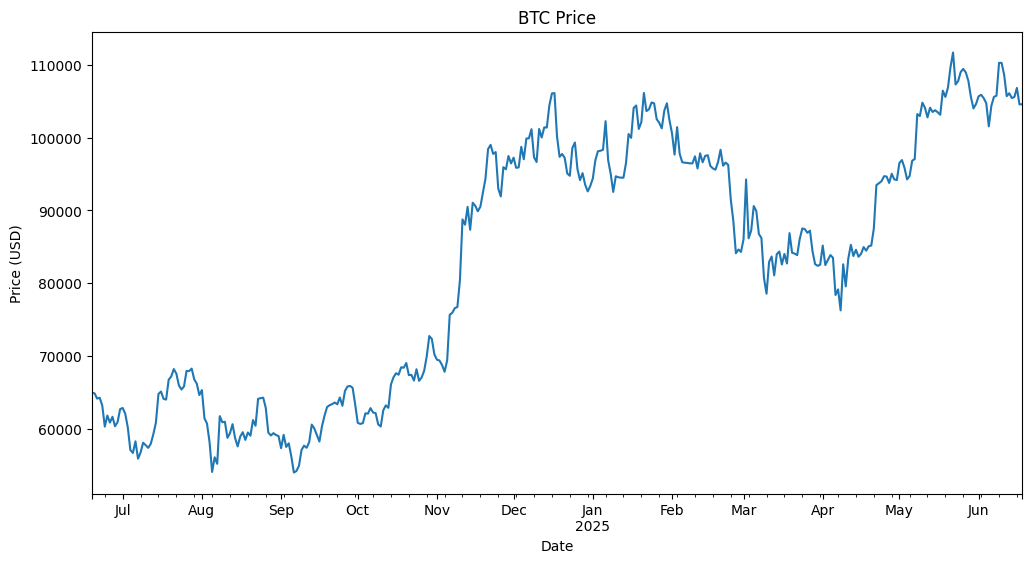

In [4]:
daily_data['close'].plot.line(title=f'{COIN} Price', figsize=(12, 6), ylabel='Price (USD)', xlabel='Date')

<Axes: ylabel='Frequency'>

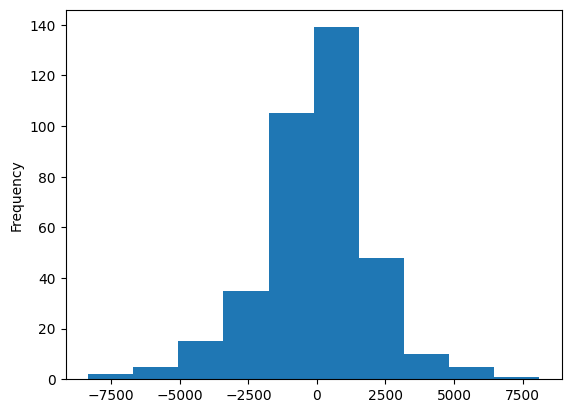

In [5]:
daily_data['gradient'].plot.hist()

In [6]:
daily_data['close'].describe()

count       365.000000
mean      82631.458164
std       17469.048631
min       53950.010000
25%       64179.630000
50%       85170.370000
75%       97444.410000
max      111722.530000
Name: close, dtype: float64

# Load the Transformer Model

Sequence the data to make it predict the next price

## Preprocess the data


In [55]:
daily_data = transformerDataSetup(daily_data)
daily_data[['sequence', 'next']].head()

,sequence,next
time,,
2024-06-19,"[-99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, ...]",64840.88
2024-06-20,"[64943.79, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, ...]",64120.28
2024-06-21,"[64943.79, 64840.88, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, -99999999.0, ...]",64235.01
202

## Load the Model

### Data Setup

In [56]:
X_train, X_test, y_train, y_test = transformerXTrainYTrain(daily_data, testSize=len(daily_data)-30)

In [32]:
from sklearn.preprocessing import StandardScaler
X_train_norm, X_test_norm, y_train_norm, y_test_norm, sequence_scaler, target_scaler = normalize(X_train, X_test, y_train, y_test)

In [22]:
model = torch.load(f'../models/{COIN}_model.pth')

Data shapes - X: torch.Size([335, 365, 1]), y: torch.Size([335, 1])
DataFrame column: sequences
Sample sequence length: 365


Training Progress: 100%|██████████| 25/25 [03:59<00:00,  9.59s/it]

Training completed!


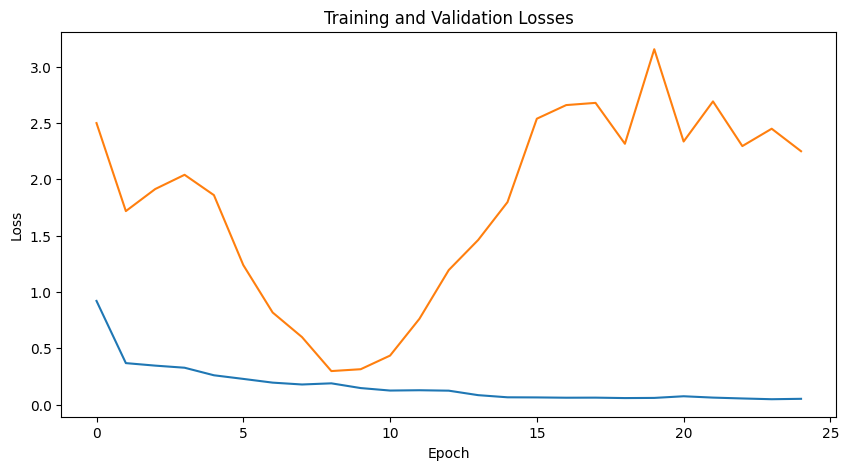

In [29]:
# Create model with appropriate settings for Bitcoin prediction
model = BaseTransformer(
    d_model=128,
    num_heads=8,
    num_layers=4,
    learning_rate=1e-4,  # This is fine now with normalized data
    batch_size=32,
    dropout=0.1,
    mask_value=FILL
)
model.fit(X_train_norm, y_train_norm, epochs=50, validation_data=(X_test_norm, y_test_norm))
torch.save(model, f'../models/{COIN}_full_model.pth')

In [41]:
predictions = model.predict(X_test_norm)
predictions = target_scaler.inverse_transform(predictions).reshape(-1)
predictions = pd.Series(predictions, index=y_test.index)
y_test_norm.index = X_test_norm.index

rmse = root_mean_squared_error(y_test, predictions)
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 24916.4952


<Axes: title={'center': 'Difference on Prediction and Actual'}, xlabel='time'>

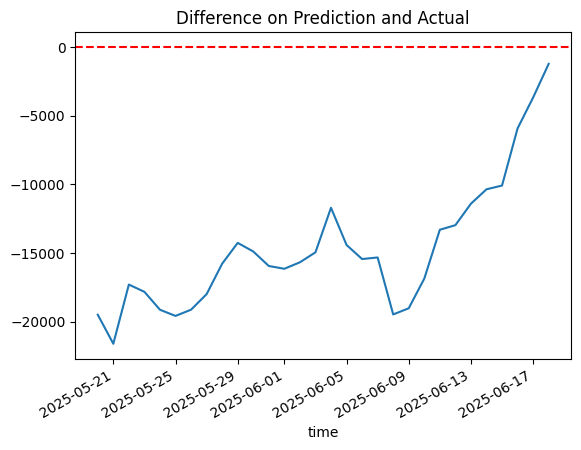

In [27]:
diff = predictions - y_test
plt.axhline(0.0, color='r', linestyle='--')
diff.plot.line(title='Difference on Prediction and Actual')

<Axes: title={'center': 'Predicted vs. Actual Value on Validation Month'}, xlabel='Date', ylabel='Price'>

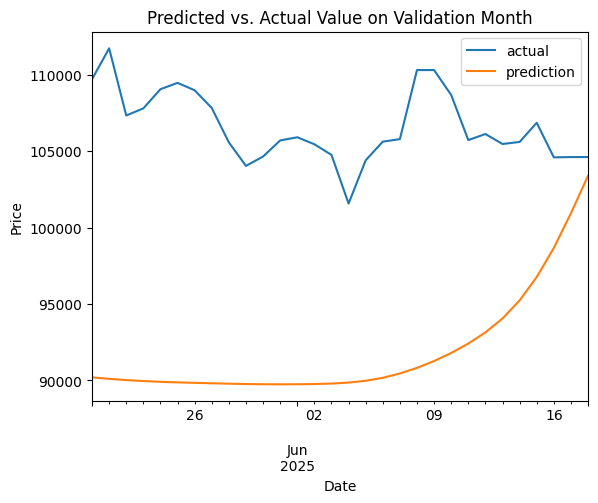

In [28]:
comparison = pd.concat([y_test, predictions], axis=1)
comparison.columns = ['actual', 'prediction']
comparison.plot.line(title='Predicted vs. Actual Value on Validation Month', xlabel='Date', ylabel='Price')

In [70]:
new = daily_data['close'].iloc[-30:]
new, next = sequence(new, len(new)-1)
new = pd.DataFrame({'sequences': [new]})
new = pd.DataFrame({
        'sequences': normalize_sequences(new.iloc[:, 0], sequence_scaler)
    })
model.predict(new, sequence_scaler)[0, 0]

107818.83

<Axes: title={'center': '20-day Predicted Sequence'}, xlabel='Days Ahead from 6/9/2025', ylabel='Price (USD)'>

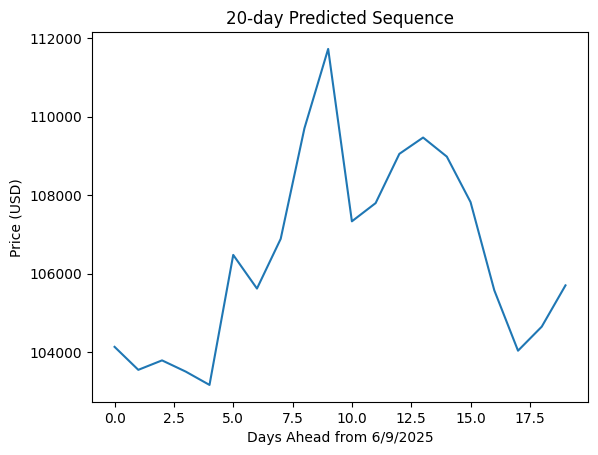

In [39]:
predictions = []
start = []
for i in range(30):
    

count        20.000000
mean     106445.147000
std        2479.269688
min      103161.070000
25%      104106.610000
50%      106085.700000
75%      108109.082500
max      111722.530000
dtype: float64